In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

In [2]:
val_pred_df = pd.read_csv(
    "./predictions/rubert_mlp_val.tsv",
    sep="\t",
    names=["id", "predicted_rating", "actual_rating"],
)

In [3]:
val_pred_df

,id,predicted_rating,actual_rating
0,0,5.051571,5.0
1,1,3.456689,3.0
2,2,5.044766,5.0
3,3,5.053782,5.0
4,4,4.903320,5.0
...,...,...,...
99955,99955,4.328075,2.0
99956,99956,5.040319,5.0
99957,99957,5.084836,5.0
99958,99958,5.080313,5.0


In [4]:
def smart_rounding(predictions, confidence_threshold=0.3):
    """
    Умное округление с порогом уверенности
    predictions: сырые предсказания модели
    confidence_threshold: порог уверенности для округления (0.1-0.4)
    """
    predictions = np.array(predictions)
    rounded = np.zeros_like(predictions)

    for i, pred in enumerate(predictions):
        decimal_part = abs(pred - round(pred))

        # Если модель "уверена" (десятичная часть мала) - округляем
        if decimal_part < confidence_threshold:
            rounded[i] = round(pred)
        else:
            # Иначе оставляем как есть (или округляем до 0.5)
            # rounded[i] = round(pred * 2) / 2  # Округляем до 0.5
            rounded[i] = pred  # Оставляем, как есть

    return np.clip(rounded, 1, 5)


# Тестируем разные пороги
test_pred = [1.1, 1.4, 2.6, 3.2, 4.1, 4.6, 4.9]
print("Сырые:", test_pred)
print("Порог 0.2:", smart_rounding(test_pred, 0.2))
print("Порог 0.3:", smart_rounding(test_pred, 0.3))
print("Порог 0.4:", smart_rounding(test_pred, 0.4))

Сырые: [1.1, 1.4, 2.6, 3.2, 4.1, 4.6, 4.9]
Порог 0.2: [1.  1.4 2.6 3.2 4.  4.6 5. ]
Порог 0.3: [1.  1.4 2.6 3.  4.  4.6 5. ]
Порог 0.4: [1.  1.  3.  3.  4.  4.6 5. ]


In [5]:
def find_optimal_threshold(raw_predictions, true_labels, thresholds=None):
    """
    Находит оптимальный порог уверенности для минимизации RMSE
    """
    if thresholds is None:
        thresholds = np.arange(0.0, 0.5, 0.05)

    best_rmse = float("inf")
    best_threshold = 0.3
    results = {}

    for threshold in thresholds:
        processed = smart_rounding(raw_predictions, threshold)
        rmse = root_mean_squared_error(true_labels, processed)
        results[threshold] = rmse

        print(f"threshold: {threshold:.4f}, RMSE: {rmse:.4f}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_threshold = threshold

    print(f"🎯 Оптимальный порог: {best_threshold:.2f}, RMSE: {best_rmse:.4f}")
    return best_threshold, best_rmse, results


val_predictions = val_pred_df["predicted_rating"]
val_true_labels = val_pred_df["actual_rating"]
# Использование (на валидационной выборке)
optimal_threshold, best_rmse, all_results = find_optimal_threshold(
    raw_predictions=val_predictions,
    true_labels=val_true_labels,
)

threshold: 0.0000, RMSE: 0.5209
threshold: 0.0500, RMSE: 0.5210
threshold: 0.1000, RMSE: 0.5217
threshold: 0.1500, RMSE: 0.5228
threshold: 0.2000, RMSE: 0.5239
threshold: 0.2500, RMSE: 0.5264
threshold: 0.3000, RMSE: 0.5293
threshold: 0.3500, RMSE: 0.5336
threshold: 0.4000, RMSE: 0.5386
threshold: 0.4500, RMSE: 0.5444
🎯 Оптимальный порог: 0.00, RMSE: 0.5209


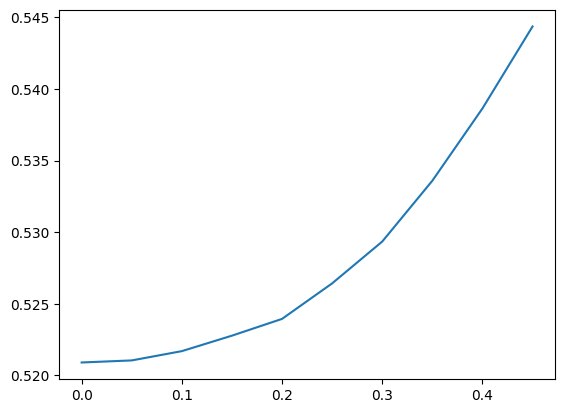

In [6]:
plt.plot(all_results.keys(), all_results.values())